In [63]:
import pandas as pd
import numpy as np
import os

data is split into 12 csv files, initial goal is to concatinate all the files into single dataframe

In [64]:
files = [f for f in os.listdir('./Sales_Data')]

for f in files:
    print(f)

Sales_December_2019.csv
Sales_April_2019.csv
Sales_February_2019.csv
Sales_March_2019.csv
Sales_August_2019.csv
Sales_May_2019.csv
Sales_November_2019.csv
Sales_October_2019.csv
Sales_January_2019.csv
Sales_September_2019.csv
Sales_July_2019.csv
Sales_June_2019.csv


In [65]:
combined_csv = pd.concat([pd.read_csv('./Sales_Data/' + f) for f in files])

df = pd.DataFrame(combined_csv)
print(np.shape(df))

(186850, 6)


In [66]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186850 entries, 0 to 13621
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 10.0+ MB


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


# Q1: Most productive month for sales

let's first clean the data, see if there are any missing values

In [67]:
df.isna().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

since sum(nan) << sum(rows) we can simply drop the rows which contain at least one missing column

In [68]:
df.dropna(how='any', inplace=True)

remove rows that contain corrupted date column, this problem became obvious as i tried to convert date to time series in the following steps

In [69]:
df=df[df["Order Date"].str[0:2] != 'Or']

In [70]:
df.index = pd.to_datetime(df['Order Date'],infer_datetime_format=True)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
Order Date,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


In [71]:
df.isnull().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
dtype: int64

In [72]:

df['Price Each']=pd.to_numeric(df['Price Each'])
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'])


create new column which corresponds to total sale i.e price X quantity

In [73]:
#df.groupby(by=[df.index.month])[df['Price Each'] * df['Quantity Ordered']].agg('sum')
df['total'] = df['Price Each'] * df['Quantity Ordered']

In [74]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total
Order Date,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95


group dataset by month, calculate sum of sales and sort them in descending order to obtain the month with highest total sales value

In [75]:
df.groupby(by=[df.index.month])['total'].agg(['sum']).sort_values(by='sum', ascending=False)

,sum
Order Date,
12,4.613443e+06
10,3.736727e+06
4,3.390670e+06
11,3.199603e+06
5,3.152607e+06
3,2.807100e+06
7,2.647776e+06
6,2.577802e+06
8,2.244468e+06


we can see that the month with highest total sales values is December, but the sale amount differences in exponential notation is not too obvious for most people, so let's express the results visually

In [76]:
from matplotlib import pyplot as plt

In [77]:
df['month'] = pd.to_numeric(df['Order Date'].str[0:2])
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month
Order Date,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00,12
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00,12
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95,12
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99,12
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95,12


In [78]:
pltmonths=range(1,13)

Text(0, 0.5, 'Sales in USD')

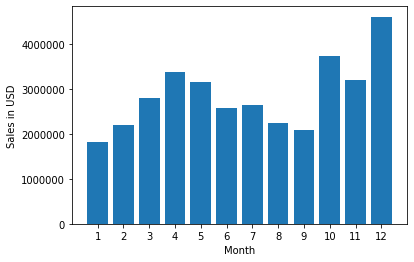

In [79]:
plt.bar(pltmonths, df.groupby('month')['total'].sum())
plt.xticks(pltmonths)
plt.xlabel("Month")
plt.ylabel("Sales in USD")

# Q2: Which city had the highest number of sales?

In [80]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month
Order Date,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00,12
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00,12
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95,12
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99,12
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95,12


as you can see city is in the middle of 3 comma separated values, in the purchace address column, so let's define a function thatextracts city value from that and create new column

In [81]:
def get_city(address):
    return address.split(',')[1]

df['city']=df['Purchase Address'].apply(lambda x: get_city(x))
    

In [83]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month,city
Order Date,,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00,12,New York City
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00,12,New York City
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95,12,New York City
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99,12,San Francisco
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95,12,Atlanta


city column has sucsessfully added to the dataframe, however city names sometimes are not unique, i.e two cities from two different countries or states might have the same name, and to make sure we don't get mixed up it would be a good idea to add corresponding state to our city column  

In [84]:
df = df.drop('city', 1)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month
Order Date,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00,12
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00,12
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95,12
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99,12
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95,12


In [101]:
def get_unique_city(address):
    ar=address.split(',')
    return ar[1] + ',' + ar[2].split()[0]

In [105]:
df['city']=df['Purchase Address'].apply(lambda x: get_unique_city(x))
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month,city
Order Date,,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",1700.00,12,"New York City,NY"
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",600.00,12,"New York City,NY"
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",11.95,12,"New York City,NY"
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",149.99,12,"San Francisco,CA"
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",11.95,12,"Atlanta,GA"


In [107]:
df.groupby('city')['total'].agg('sum').sort_values(ascending=False)

city
 San Francisco,CA    8.262204e+06
 Los Angeles,CA      5.452571e+06
 New York City,NY    4.664317e+06
 Boston,MA           3.661642e+06
 Atlanta,GA          2.795499e+06
 Dallas,TX           2.767975e+06
 Seattle,WA          2.747755e+06
 Portland,OR         1.870732e+06
 Austin,TX           1.819582e+06
 Portland,ME         4.497583e+05
Name: total, dtype: float64

In [115]:
srs=df.groupby('city')['total'].agg('sum').sort_values(ascending=False)
srs=pd.DataFrame(srs)
srs['city']=srs.index
type(srs)
srs.head()

,total,city
city,,
"San Francisco,CA",8.262204e+06,"San Francisco,CA"
"Los Angeles,CA",5.452571e+06,"Los Angeles,CA"
"New York City,NY",4.664317e+06,"New York City,NY"
"Boston,MA",3.661642e+06,"Boston,MA"
"Atlanta,GA",2.795499e+06,"Atlanta,GA"


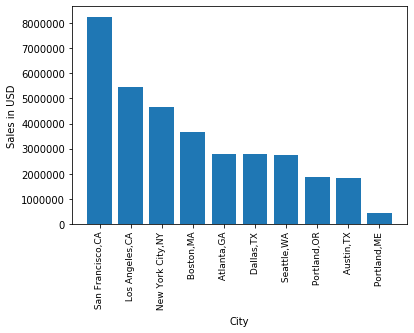

In [118]:
plt.bar(srs['city'], srs['total'])
plt.xlabel('City')
plt.ylabel('Sales in USD')
plt.xticks(srs['city'], rotation='vertical', size=9)
plt.show()

# Q3: What time should we display advertisemens to maximize the likelihood of customer’s buying product?

let's first extract hour from date and add it to our dataset as a new column

In [121]:
df['Order Date']=pd.to_datetime(df['Order Date'])

df['hour']=df['Order Date'].dt.hour

In [122]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month,city,hour
Order Date,,,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",1700.00,12,"New York City,NY",0
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",600.00,12,"New York City,NY",7
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",11.95,12,"New York City,NY",18
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",149.99,12,"San Francisco,CA",15
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",11.95,12,"Atlanta,GA",12


In [132]:
toptime = pd.DataFrame(df.groupby('hour')['total'].agg('sum').sort_values(ascending=False))
toptime['hour']=toptime.index
toptime.reset_index(drop=True, inplace=True)
toptime.head()

,total,hour
0,2412938.54,19
1,2316821.34,12
2,2300610.24,11
3,2281716.24,20
4,2219348.30,18


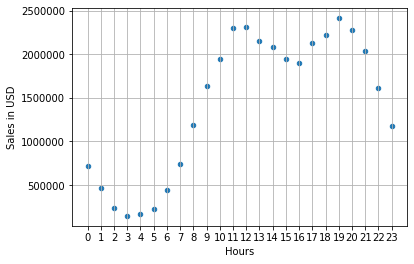

In [144]:
plt.scatter(toptime['hour'], toptime['total'], s=20)
plt.xticks(toptime['hour'])
plt.xlabel('Hours')
plt.ylabel('Sales in USD')
plt.grid()
plt.show()

By closely Analysing the plot above it can be deduced  that the best time frame for placing advertisments is from 11:00 to 12:00 and from 18:00 to 20:00 as sales tend to peak during these time intervals.

But, of course, this answer assumes idealised situation as sales from all cities were summed and sorted, in real world one would have to consider location and statistics from each branch.

# Q4:  What products are most often sold together?

products that are bought together will obviously have the same order id, so as a first step it would make sence to extract dublicated order id rows from the dataframe

In [145]:
dfd = df[df["Order ID"].duplicated(keep=False)]

In [146]:
dfd.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month,city,hour
Order Date,,,,,,,,,,
2019-12-25 12:37:00,295681,Google Phone,1,600.00,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",600.00,12,"Boston,MA",12
2019-12-25 12:37:00,295681,USB-C Charging Cable,1,11.95,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",11.95,12,"Boston,MA",12
2019-12-25 12:37:00,295681,Bose SoundSport Headphones,1,99.99,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",99.99,12,"Boston,MA",12
2019-12-25 12:37:00,295681,Wired Headphones,1,11.99,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",11.99,12,"Boston,MA",12
2019-12-13 14:32:00,295698,Vareebadd Phone,1,400.00,2019-12-13 14:32:00,"175 1st St, New York City, NY 10001",400.00,12,"New York City,NY",14


let's now merge the duplicate rows into one, so that product column contains all the products together, with comma separated values

In [147]:
dfd['merged']=dfd.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [148]:
dfd.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month,city,hour,merged
Order Date,,,,,,,,,,,
2019-12-25 12:37:00,295681,Google Phone,1,600.00,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",600.00,12,"Boston,MA",12,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
2019-12-25 12:37:00,295681,USB-C Charging Cable,1,11.95,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",11.95,12,"Boston,MA",12,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
2019-12-25 12:37:00,295681,Bose SoundSport Headphones,1,99.99,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",99.99,12,"Boston,MA",12,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
2019-12-25 12:37:00,295681,Wired Headphones,1,11.99,2019-12-25 12:37:00,"79 Elm St, Boston, MA 02215",11.99,12,"Boston,MA",12,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
2019-12-13 14:32:00,295698,Vareebadd Phone,1,400.00,2019-12-13 14:32:00,"175 1st St, New York City, NY 10001",400.00,12,"New York City,NY",14,"Vareebadd Phone,USB-C Charging Cable"


since we already have all the data we need in the merged column, let's now drop the duplicates and the rest of unnecessary data

In [149]:
dfd=dfd[["Order ID", "merged"]].drop_duplicates()
dfd.head()

,Order ID,merged
Order Date,,
2019-12-25 12:37:00,295681,"Google Phone,USB-C Charging Cable,Bose SoundSp..."
2019-12-13 14:32:00,295698,"Vareebadd Phone,USB-C Charging Cable"
2019-12-17 12:27:00,295703,"AA Batteries (4-pack),Bose SoundSport Headphones"
2019-12-25 14:49:00,295726,"iPhone,Lightning Charging Cable"
2019-12-22 18:25:00,295735,"iPhone,Apple Airpods Headphones,Wired Headphones"


now what we need to do is to count which pair of products occur most frequently. one way to do this is to create one large list containing lists of all items within order from merged column and use .Counter() on it

In [151]:
from itertools import combinations
from collections import Counter

In [159]:
count=Counter()
for row in dfd['merged']:
    row_list=row.split(',')
    count.update(Counter(combinations(row_list, 2)))

after each iteration the above code stores a list of all products within an order into a list, then creates all possible combinations of 2 products and counts which combanation occurs most frequently 

In [165]:
print(count.most_common(15))

[(('iPhone', 'Lightning Charging Cable'), 1005), (('Google Phone', 'USB-C Charging Cable'), 987), (('iPhone', 'Wired Headphones'), 447), (('Google Phone', 'Wired Headphones'), 414), (('Vareebadd Phone', 'USB-C Charging Cable'), 361), (('iPhone', 'Apple Airpods Headphones'), 360), (('Google Phone', 'Bose SoundSport Headphones'), 220), (('USB-C Charging Cable', 'Wired Headphones'), 160), (('Vareebadd Phone', 'Wired Headphones'), 143), (('Lightning Charging Cable', 'Wired Headphones'), 92), (('Lightning Charging Cable', 'Apple Airpods Headphones'), 81), (('Vareebadd Phone', 'Bose SoundSport Headphones'), 80), (('USB-C Charging Cable', 'Bose SoundSport Headphones'), 77), (('Apple Airpods Headphones', 'Wired Headphones'), 69), (('Lightning Charging Cable', 'USB-C Charging Cable'), 58)]


why am I not surprised...

# Q6: Which product sold the most? Why do you think it sold the most?

In [166]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,total,month,city,hour
Order Date,,,,,,,,,,
2019-12-30 00:01:00,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",1700.00,12,"New York City,NY",0
2019-12-29 07:03:00,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",600.00,12,"New York City,NY",7
2019-12-12 18:21:00,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",11.95,12,"New York City,NY",18
2019-12-22 15:13:00,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",149.99,12,"San Francisco,CA",15
2019-12-18 12:38:00,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",11.95,12,"Atlanta,GA",12


In [168]:
most = pd.DataFrame(df.groupby('Product')['Quantity Ordered'] \
                    .agg('sum').sort_values(ascending=False))

In [169]:
most.head()

,Quantity Ordered
Product,
AAA Batteries (4-pack),31017
AA Batteries (4-pack),27635
USB-C Charging Cable,23975
Lightning Charging Cable,23217
Wired Headphones,20557


In [170]:
most['name']=most.index
most.reset_index(inplace=True, drop=True)

In [171]:
most.head()

,Quantity Ordered,name
0,31017,AAA Batteries (4-pack)
1,27635,AA Batteries (4-pack)
2,23975,USB-C Charging Cable
3,23217,Lightning Charging Cable
4,20557,Wired Headphones


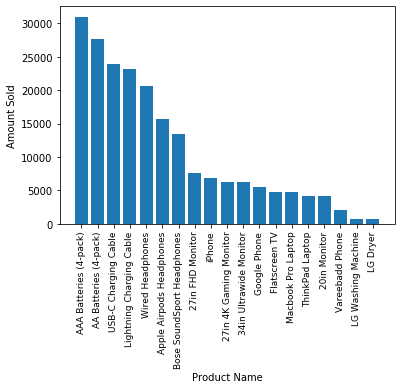

In [173]:
plt.bar(most['name'], most['Quantity Ordered'])
plt.xlabel('Product Name')
plt.ylabel('Amount Sold')
plt.xticks(most['name'], rotation='vertical', size=9)
plt.show()

it can be seen from the above chart that AAA battery pack was the most frequently sold item, with apple lightning cable being a close second, as to why this was the case two arguments come to my mind:

1 - one reason is that these items are designed not to be permanent, i.e their lifespan is not particularly long
2 - the items that cost less are the same items that are sold most

the latter hypothesis can actually be tested with our data, so let's just do that

In [185]:
cost = pd.DataFrame(df.groupby('Product')['Price Each'] \
                    .agg('mean').sort_values(ascending=False))

In [186]:
cost.head()

,Price Each
Product,
Macbook Pro Laptop,1700.00
ThinkPad Laptop,999.99
iPhone,700.00
LG Dryer,600.00
LG Washing Machine,600.00


In [187]:
cost['name']=cost.index
cost.reset_index(inplace=True, drop=True)
cost.head()

,Price Each,name
0,1700.00,Macbook Pro Laptop
1,999.99,ThinkPad Laptop
2,700.00,iPhone
3,600.00,LG Dryer
4,600.00,LG Washing Machine


one way to do this is visual, to overlay the mean price of products to their quantity sold:

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


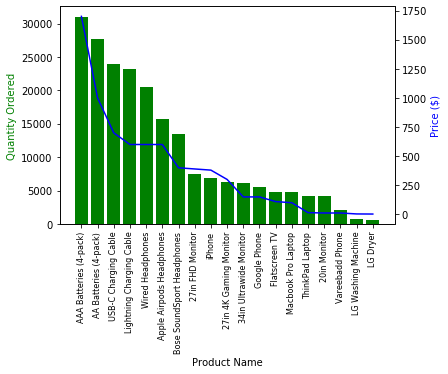

In [188]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.bar(most['name'], most['Quantity Ordered'], color='g')
ax2.plot(most['name'], cost['Price Each'], color='b')

ax1.set_xlabel('Product Name')
ax1.set_ylabel('Quantity Ordered', color='g')
ax2.set_ylabel('Price ($)', color='b')
ax1.set_xticklabels(most['name'], rotation='vertical', size=8)

fig.show()

This shows that the correlatoin between price and the quantity sold is statistically significant and thus increases plausability of our second hypothesis.

to make sure that we did not unintentially expressed plots in such a way as to conform to our predictions, let us also calculate correlation between these two variables. since relationship seems to be nonlinear let us use Spearman's method.

In [189]:
from scipy.stats import spearmanr

In [191]:
corr, _ = spearmanr(cost['Price Each'], most['Quantity Ordered'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.998


as expected. the correlation is highly statistically significant.